# **Movie Recommender System**

In this project we will use MovieLens, a recommender system that was developed by GroupLens, a computer science research lab at the University of Minnesota. It recommends movies to its users based on their movie ratings. It is also a dataset that is widely used in research and teaching contexts.

### **Step 1: Import Dependancies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Step 2: Load Data**

In this project we Load MovieTweetings dataset directly from GitHub. You don't need to download any aditional files to use it. (https://github.com/sidooms/MovieTweetings)


In [2]:
movies_url = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/movies.dat"
ratings_url = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat"

# These use "::" as separator
movies = pd.read_csv(movies_url, sep="::", engine='python', names=["movieId", "title", "genres"])
ratings = pd.read_csv(ratings_url, sep="::", engine='python', names=["userId", "movieId", "rating", "timestamp"])


In [3]:
movies.head()


,movieId,title,genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines Lumière (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,NaN
4,91,Le manoir du diable (1896),Short|Horror


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,114508,8,1381006850
1,2,499549,9,1376753198
2,2,1305591,8,1376742507
3,2,1428538,1,1371307089
4,3,75314,1,1595468524


### **Step 3: Data analyses**



In [5]:
print(f'Number of movies: {movies.shape[0]}')
print(f'Number of ratings: {ratings.shape[0]}')
print(f'Number of unique users: {ratings.userId.nunique()}')
print(f'Number of ratings per user: {ratings.shape[0] / ratings.userId.nunique()}')
print(f'Number of ratings per movie: {ratings.shape[0] / ratings.movieId.nunique()}')


Number of movies: 38018
Number of ratings: 921398
Number of unique users: 71707
Number of ratings per user: 12.849484708605855
Number of ratings per movie: 24.239023491963277


### What is the distribution of ratings?

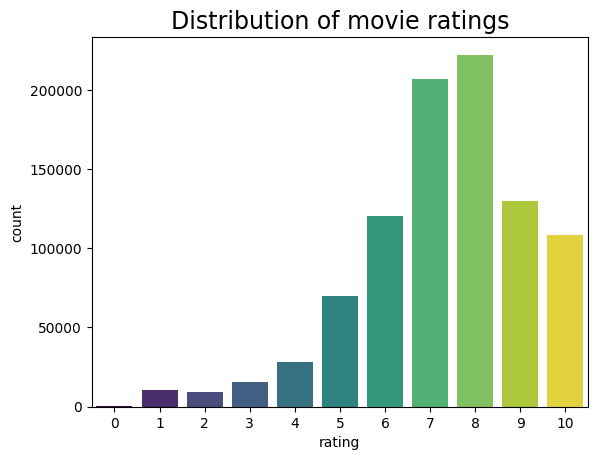

In [6]:
sns.countplot(x="rating", data=ratings, hue = "rating", palette="viridis", legend = False)
plt.title("Distribution of movie ratings", fontsize=17)
plt.show()

In [7]:
print(f'Mean global rating: {round(ratings.rating.mean()) }')

Mean global rating: 7


### What movies are constantly rated?



In [8]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

,count
title,
Gravity (2013),3104
Interstellar (2014),2964
1917 (2019),2893
The Wolf of Wall Street (2013),2842
Joker (2019),2757
Man of Steel (2013),2699
World War Z (2013),2431
Iron Man Three (2013),2425
Now You See Me (2013),2380


Gravity, Interstellar and 1917 have the most amount of ratings

### What are the highest and lowest rated movies ever?

In [9]:
print(f'Highest rated movie: {movie_ratings.groupby("title")["rating"].mean().sort_values(ascending=False).index[0]}')
print(f'Lowest rated movie: {movie_ratings.groupby("title")["rating"].mean().sort_values(ascending=True).index[0]}')

Highest rated movie: ...Og det var Danmark (2008)
Lowest rated movie: Les filles du soleil (2018)


### How many ratings does Og det ver Danmark have?

In [10]:
ratings[ratings['movieId'] == movie_ratings.groupby("movieId")["rating"].mean().sort_values(ascending=False).index[0]]

,userId,movieId,rating,timestamp
4508,279,16058736,10,1637095151


Since it only has 1 rating let's use a different approach using Bayesian average.

### Bayesian average.

Bayesian average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where  C  represents our confidence,  m  represents our prior, and  N  is the total number of reviews for movie  i . In this case, our prior  m  will be the average mean rating across all movies. By defintion, C represents "the typical data set size". Let's make  C  be the average number of ratings for a given movie.

In [11]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
8,1,5.0
10,1,10.0
12,1,10.0
25,1,8.0
91,3,6.0


In [12]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 24.24
Average rating for a given movie: 6.66


In [13]:
Og_det = pd.Series([5, 5])
bayesian_avg(Og_det)

np.float64(6.529)

The Bayesian Average of the movie Og det ver Danmark have is *6.529*

Now, let's apply our Bayesian average to all movies in our dataset.

In [14]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [15]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False)

,movieId,count,mean,bayesian_avg,title
32266,5512872,353,9.985836,9.772,Be Somebody (2016)
8935,111161,1177,9.388275,9.333,The Shawshank Redemption (1994)
15200,468569,740,9.279730,9.196,The Dark Knight (2008)
10824,167260,392,9.346939,9.190,The Lord of the Rings: The Return of the King ...
2184,50083,874,9.210526,9.142,12 Angry Men (1957)
...,...,...,...,...,...
32580,5690360,51,2.803922,4.045,Slender Man (2018)
25031,2467046,99,3.363636,4.011,Left Behind (2014)
10076,120863,262,3.656489,3.910,The Thin Red Line (1998)
30323,4458206,30,1.000000,3.527,Kod Adi K.O.Z. (2015)


Using the Bayesian average, we see that `Be somebody`, `The Shawshank Redemption`, and `The Dark Knight` are the most highly rated movies. The result of latter two makes much more sense since these movies are critically acclaimed films. Nevertheless,  `Be somebody` seems to be really favoured in this movie dataset.

The lowest rated movies using Bayesian average are `The Rat`, `Kod Adi K.O.Z.` and `The Thin Red Line`.

The standings chaned quite a lot, right?

### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [16]:
movies['genres'] = movies['genres'].astype(str).apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),"[Documentary, Short]"
1,10,La sortie des usines Lumière (1895),"[Documentary, Short]"
2,12,The Arrival of a Train (1896),"[Documentary, Short]"
3,25,The Oxford and Cambridge University Boat Race ...,[nan]
4,91,Le manoir du diable (1896),"[Short, Horror]"


In [17]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 29 genres.


Counter({'Documentary': 3675,
         'Short': 1551,
         'nan': 54,
         'Horror': 4797,
         'Comedy': 11793,
         'Action': 5745,
         'Adventure': 3426,
         'Fantasy': 2376,
         'Sci-Fi': 2613,
         'Crime': 5106,
         'Western': 537,
         'Drama': 19310,
         'Romance': 6475,
         'History': 1455,
         'Family': 2107,
         'War': 1301,
         'Sport': 946,
         'Biography': 1932,
         'Mystery': 2883,
         'Thriller': 8006,
         'Animation': 1442,
         'Music': 1304,
         'Musical': 875,
         'Film-Noir': 287,
         'Adult': 11,
         'Talk-Show': 5,
         'News': 113,
         'Reality-TV': 9,
         'Game-Show': 1})

In [18]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 19310), ('Comedy', 11793), ('Thriller', 8006), ('Romance', 6475), ('Action', 5745)]


The top genres are:

('Drama', 19310), ('Comedy', 11793), ('Thriller', 8006), ('Romance', 6475), ('Action', 5745)

Let's visualize the popularity using balprot



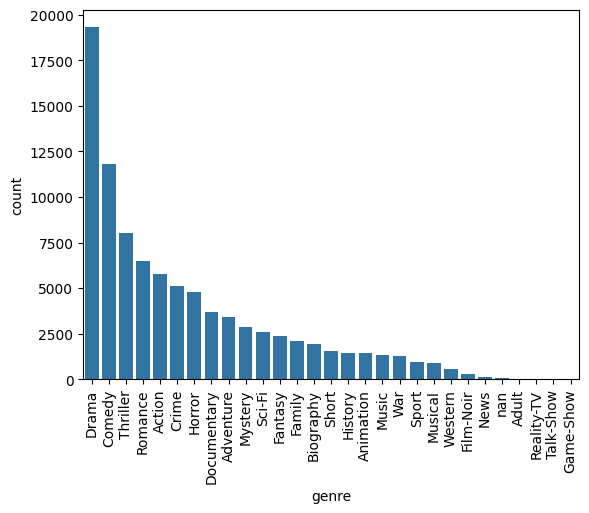

In [19]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### **Step 4: Data Pre-processing**

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.


The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [20]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [21]:
X.shape

(71707, 38013)

Our `X` matrix contains 71707 users and 38013 movies.

### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

In [21]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [22]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

71707

In [23]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2875 movies.
Least active user rated 1 movies.


In [24]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

38013

In [25]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 3104 ratings.
Least rated movie has 1 ratings.


<ipython-input-26-44089890dcd7>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
<ipython-input-26-44089890dcd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


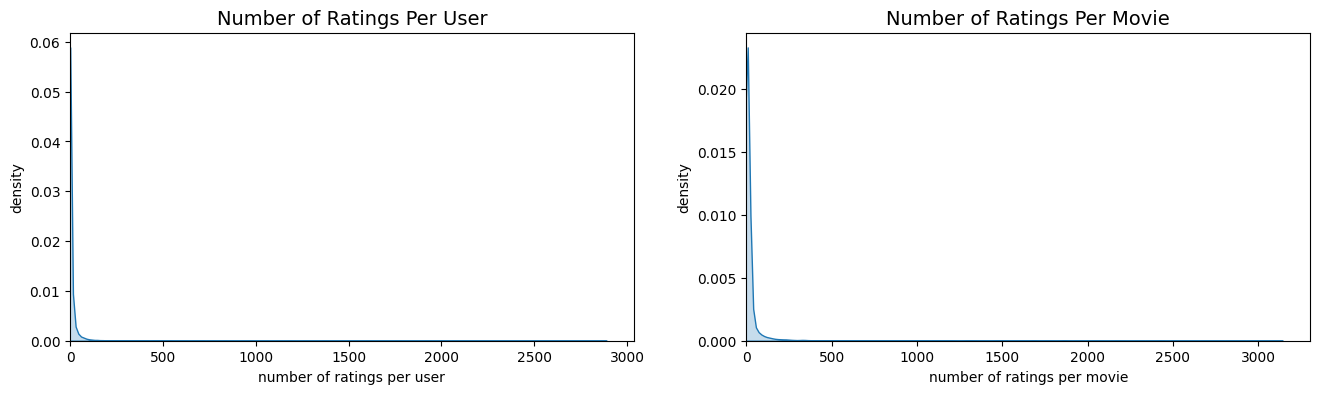

In [26]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Step 5: Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [33]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` takes in a `movieId` and `X` matrix, and outputs a list of $k$ movies that are similar to the `movieId` of interest.

Let's see how it works in action. We will first create another mapper that maps movieId to title so that our results are interpretable.

In [36]:
similar_movies = find_similar_movies(25, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[np.int64(2226495),
 np.int64(783233),
 np.int64(1878870),
 np.int64(3631112),
 np.int64(5580390),
 np.int64(1355644),
 np.int64(4160708),
 np.int64(4925292),
 np.int64(4846340)]

`find_similar_movies()` returns a list of `movieId`'s that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `movieId` to `title`.

In [38]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 25

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched The Oxford and Cambridge University Boat Race (1895):
Not Safe for Work (2014)
Atonement (2007)
The Edge of Seventeen (2016)
The Girl on the Train (2016)
The Shape of Water (2017)
Passengers (2016)
Don&x27;t Breathe (2016)
Lady Bird (2017)
Hidden Figures (2016)


The results above show the 10 movies that are most similar to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [40]:
movie_id = 25

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched The Oxford and Cambridge University Boat Race (1895):
El rey de Najayo (2012)
Les filles du soleil (2018)
Le lac des morts vivants (1981)
Stasis (2017)
Hangmen (1987)
Root Cause (2019)
Jurassic Attack (2013)
Art Is... The Permanent Revolution (2012)
Kanchana 2 (2015)


### Step 6: Handling the cold-start problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the **cold start problem**. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [41]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 38013 unique movies in our movies dataset.


In [42]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [43]:
movie_genres.head()

,Film-Noir,Short,Action,Horror,Crime,Talk-Show,Family,History,Fantasy,News,...,Reality-TV,Adventure,Thriller,Sci-Fi,Western,Game-Show,Mystery,nan,Sport,Romance
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (38018, 38018)


As expected, after passing the `movie_genres` dataframe into the cosine_similarity() function, we get a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

### Creating a movie finder function
Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, Jumanji is actually listed as 'Jumanji (1995)'. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in. Let's create a function called `movie_finder()` which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

In [46]:
!pip install fuzzywuzzy

In [47]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Let's test with Jumanji

In [48]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To get relevant recommendations for `Jumanji`, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices:

In [49]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 9131


Using this handy `movie_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [50]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

:`similar_movies` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe.

In [51]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


,title
136,The Wizard of Oz (1925)
5484,Herbie Goes Bananas (1980)
7510,Little Monsters (1989)
7997,Hook (1991)
9131,Jumanji (1995)
9637,The Borrowers (1997)
10296,Astérix &amp; Obélix contre César (1999)
10770,Stuart Little (1999)
11131,The Little Vampire (2000)
11845,Astérix &amp; Obélix: Mission Cléopâtre (2002)


Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s.

We can test our recommender further with other movie titles. For your convenience, let's package the steps into a single function which takes in the movie title of interest and number of recommendations.

In [52]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [53]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
5032                                  The Rescuers (1977)
6596                      Astérix chez les Bretons (1986)
7689    DuckTales: The Movie - Treasure of the Lost La...
9252                                     Toy Story (1995)
9921                                   Toy Story 2 (1999)
Name: title, dtype: object


### Step 7: Dimensionality Reduction with Matrix Factorization (advanced)

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X} $$


In [54]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(38013, 20)

In [56]:
movie_id = 25
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched The Oxford and Cambridge University Boat Race (1895):
La noche de los lápices (1986)
Outrageous! (1977)
Kiki (2016)
De Artificiali Perspectiva (1991)
Nasser 56 (1996)
Akazib hawa (1969)
When Two Worlds Collide (2016)
Speed Sisters (2015)
Antarctica (2008)


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as movie genre.
